<a href="https://colab.research.google.com/github/pwessling/GEOGloWS/blob/main/Uso_da_API_GEOGloWS_ECMWF_Streamflow_Services_Brasil.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **GEOGloWS ECMWF Streamflow Services - Brasil**

GEOGloWS ECMWF Streamflow Services (GESS) é um modelo hidrológico global que fornece aos usuários:

1.   **Um ensemble de previsão de vazão de curto prazo com 51 membros e um horizonte de 15 dias**. A resolução temporal da previsão varia com os dias de antecedência. Nos primeiros 6 dias, a resolução temporal é de 3 horas. Do dia 7 ao dia 15, a resolução temporal é de 6 horas.
2.   **Uma previsão de vazão em curto prazo de alta resolução com um horizonte de 10 dias**. A resolução temporal do prognóstico varia com os dias de antecedência. Os primeiros 4 dias têm uma resolução temporal de 1 hora. Os dias 5 e 6 têm uma resolução temporal de 3 horas. Dos dias 7 ao dia 10, a resolução temporal é de 6 horas.
3.   **Uma simulação histórica de vazão de 01/01/1979 a 30/09/2021 com resolução diária**.

A previsão hidrológica é calculada a partir do sistema de previsão meteorológica do ECMWF, que possui 51 membros com resolução de 18 km para os primeiros 10 dias (dias 1 a 10) e resolução de 36 km para os próximos 5 dias (dias 11 a 15). Essas previsões meteorológicas são convertidas em escoamento usando o modelo hidrológico HTESSEL. Posteriormente, esses resultados são reduzidos de escala usando uma metodologia de ponderação de grade para vetor, e em seguida, são roteados através da rede de drenagem usando o modelo RAPID.

Além disso, há uma simulação histórica que foi utilizada para definir os períodos de retorno com os quais são estabelecidos os níveis de alerta em cada trecho de rio simulado. Essa simulação histórica é baseada na reanálise ERA5, que é convertida em escoamento usando o modelo HTESSEL. Esses valores de escoamento são reduzidos de escala e transitados usando o modelo RAPID. Em seguida, os resultados dessa simulação histórica são utilizados para calcular os valores de vazão correspondentes a 2, 5, 10, 25, 50 e 100 anos usando a distribuição de probabilidade Gumbel.

Esses serviços estão disponíveis para quase todos os rios do mundo com áreas de drenagem menores que 150 km². Abaixo estão mostradas as áreas onde o modelo está sendo executado atualmente.

1_1.png

Esses serviços globais são facilmente personalizáveis para uma região, país ou bacia de interesse. O primeiro passo é a extração das seções dos rios para a área de interesse. Abaixo está o processo de como isso foi feito para o Brasil.

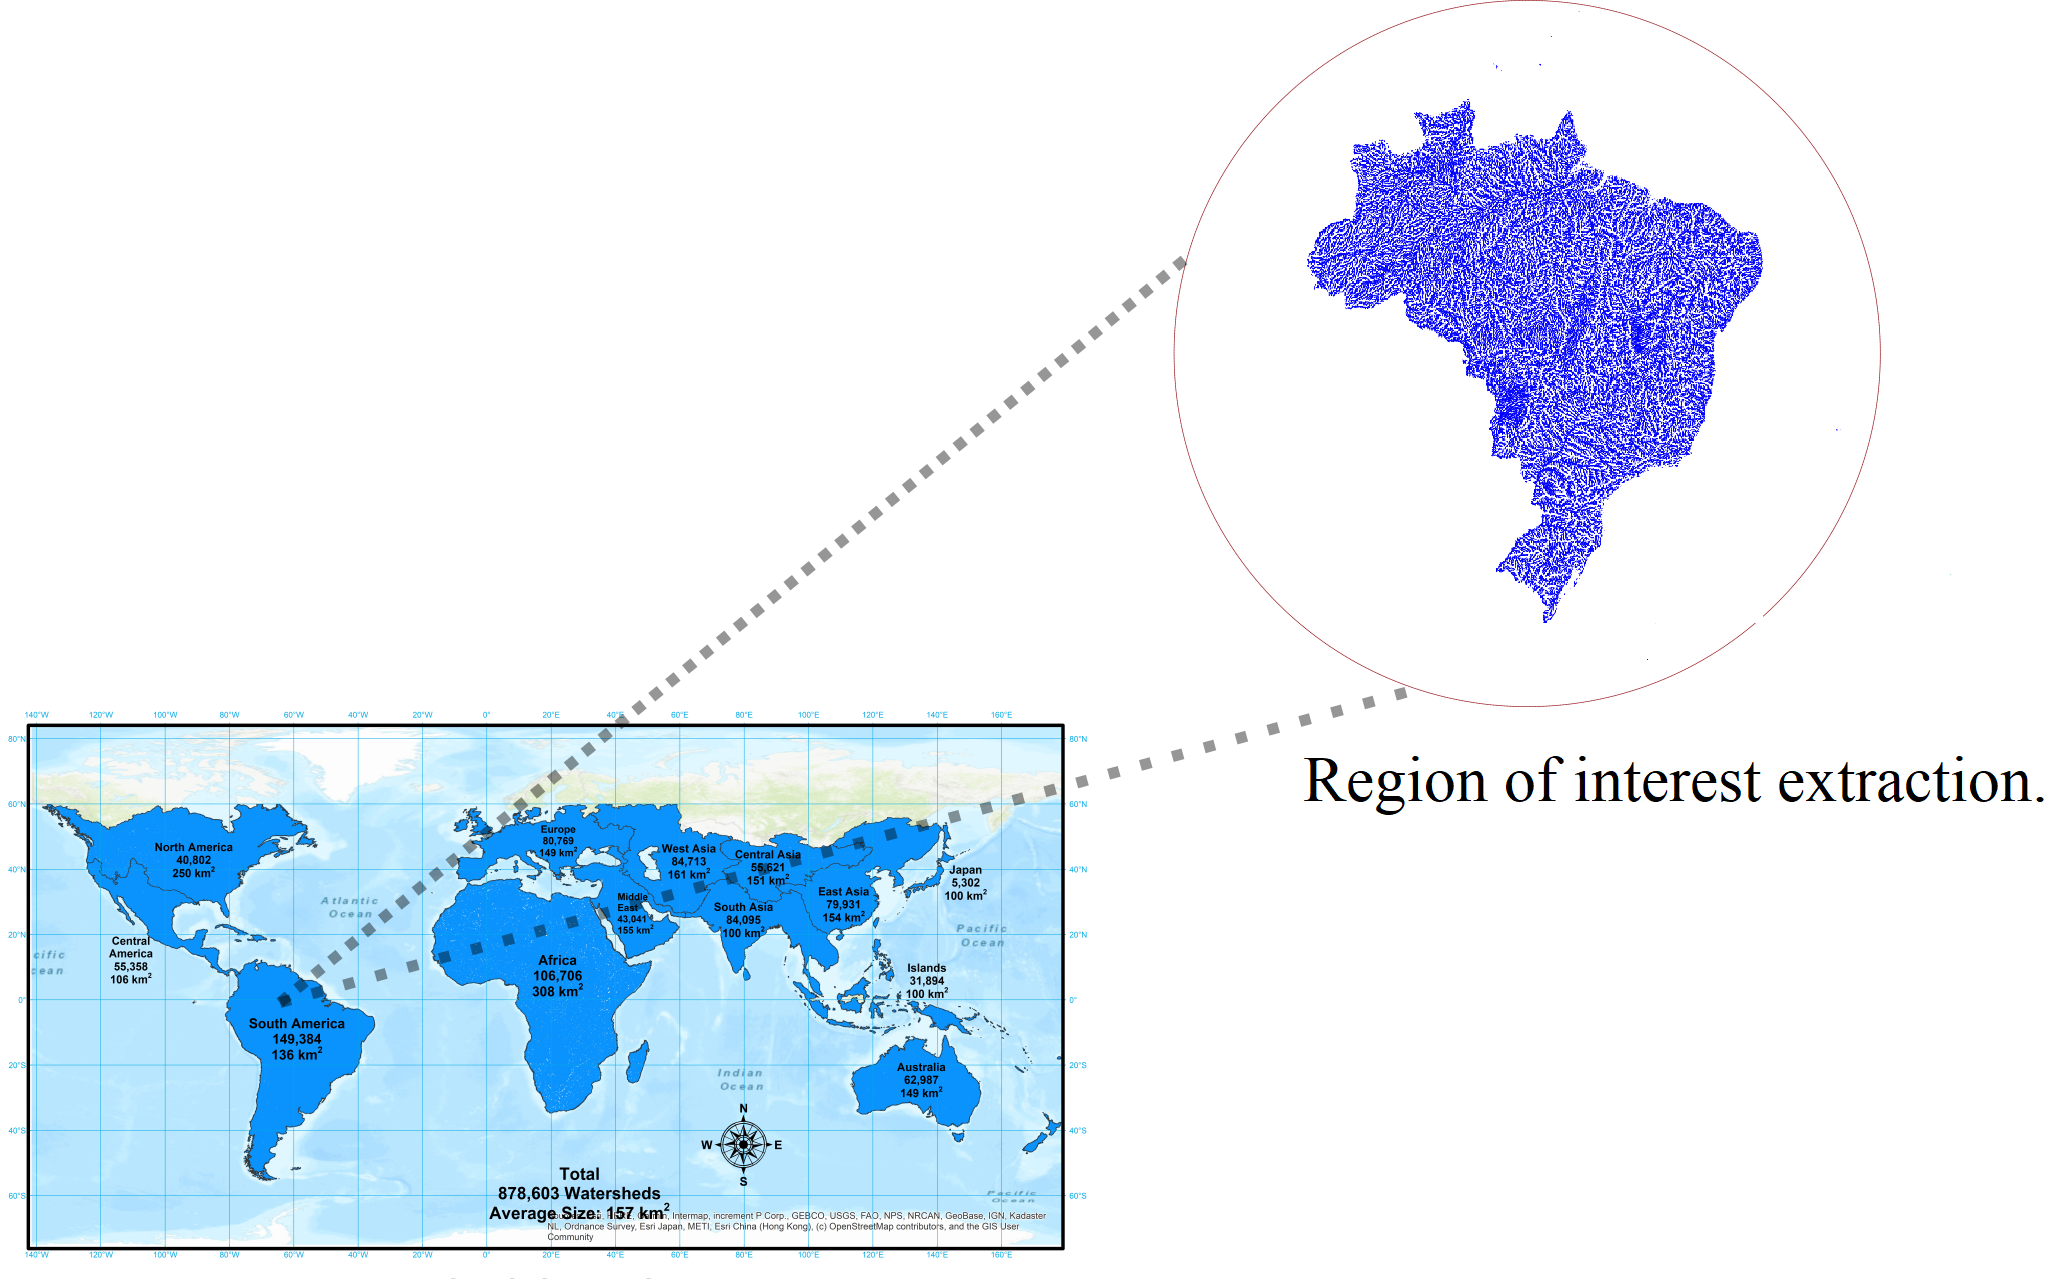

A rede de cursos d'água do Brasil pode ser baixada a partir do seguinte URL:

https://www.hydroshare.org/resource/cff2657bc8244560b559320162bf8ce4/

**Nome do arquivo: south_america-brazil-geoglows-drainage_line**

Quando você abrir a tabela de atributos, deverá encontrar um atributo chamado COMID. Este atributo é o que usamos para acessar a REST API do modelo GESS.

A documentação para o uso da REST API do modelo GESS está disponível em:

https://geoglows.ecmwf.int/documentation.

# **Pacotes Python a serem utilizados**

No desenvolvimento deste tutorial, as seguintes bibliotecas serão utilizadas.

1.   requests
2.   datetime
3.   plotly
4.   io
5.   pandas
6.   geoglows
7.   hydrostats
8.   numpy

In [ ]:
!pip install geoglows

In [ ]:
import io
import json
import requests
import geoglows
import numpy as np
import pandas as pd
import datetime as dt
import hydrostats.data
import geopandas as gpd
import plotly.express as px
from google.colab import files
import plotly.graph_objs as go
from pandas.io.json import json_normalize
from IPython.core.display import display, HTML

import warnings
warnings.filterwarnings('ignore')

# **Simulação Histórica**

Para obter a simulação histórica de qualquer trecho de rio, é necessário o COMID correspondente. A REST API irá gerar um link que permite o download da simulação histórica no formato CSV ou JSON, de acordo com o interesse do usuário.

Com o shapefile anterior, selecione o trecho de rio de interesse e obtenha o COMID correspondente. Neste tutorial, usaremos o seguinte COMID = 9043448, que corresponde ao rio Tocantins na estação Itupiranga.

A URL gerada para obter a simulação histórica terá a seguinte forma:
https://geoglows.ecmwf.int/api/HistoricSimulation/?reach_id={COMID}&return_format={formato}


O COMID fornecido dependerá do trecho do rio e o formato deve ser CSV ou JSON.

In [ ]:
lat = -5.1281
lon = -49.3242
comid = 9043448
station_name = 'Rio Tocantins na estação Itupiranga'

df = pd.DataFrame({
    'Longitude' : [lon],
    'Latitude'  : [lat],
    'Name' : station_name,
    'COMID' : str(comid)
})

geo_df = gpd.GeoDataFrame(
    data=df,
    geometry=gpd.points_from_xy(df.Longitude, df.Latitude)
).set_crs('epsg:4326')

fig = px.scatter_mapbox(
    geo_df,
    lat=geo_df.geometry.y,
    lon=geo_df.geometry.x,
    hover_name='Name',
    hover_data=['COMID'],
    color_discrete_sequence=["red"],
    zoom=5,
    height=500
)

fig.update_layout(
    mapbox_style="open-street-map",
    mapbox_layers=[
        {
            "below": 'traces',
            "sourcetype": "raster",
            "sourceattribution": "ESRI",
            "source": [
                "https://services.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}"]
        },
        {
            "below": 'traces',
            "sourcetype": "raster",
            "sourceattribution": "ESRI",
            "source": [
                "https://services.arcgisonline.com/ArcGIS/rest/services/Reference/World_Boundaries_and_Places/MapServer/tile/{z}/{y}/{x}"
            ]
        },
    ]
)

fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [ ]:
comid = 9043448

In [ ]:
era_res = requests.get('https://geoglows.ecmwf.int/api/HistoricSimulation/?reach_id={0}&return_format=csv'.format(comid), verify=False).content

simulated_df = pd.read_csv(io.StringIO(era_res.decode('utf-8')), index_col=0)
simulated_df.index = pd.to_datetime(simulated_df.index)
simulated_df[simulated_df < 0] = 0
simulated_df.index = simulated_df.index.to_series().dt.strftime("%Y-%m-%d")
simulated_df.index = pd.to_datetime(simulated_df.index)
simulated_df = simulated_df.loc[simulated_df.index <= pd.to_datetime("2022-05-31")]

display(HTML(simulated_df.to_html()))

# **Períodos de Retorno**
A REST API gerará um link que permite o download das vazões para os períodos de retorno de 2, 5, 10, 25, 50 e 100 anos da simulação histórica, em formato csv ou json, de acordo com o interesse do usuário.

A URL gerada tem o seguinte formato: https://geoglows.ecmwf.int/api/ReturnPeriods/?reach_id={COMID}&return_format={formato}

O COMID fornecido dependerá do trecho do rio e o formato deve ser csv ou json.

In [ ]:
rp_res = requests.get('https://geoglows.ecmwf.int/api/ReturnPeriods/?reach_id={0}&return_format=csv'.format(comid), verify=False).content
rperiods_df = pd.read_csv(io.StringIO(rp_res.decode('utf-8')), index_col=0)

display(HTML(rperiods_df.to_html()))

# **Gráficos**
O pacote Python Geoglows foi criado para manipular os resultados da API de uma maneira mais simples.

A função geoglows.plots.historic_simulation(simulated_df, rperiods_df, titles) tem como parâmetros de entrada o dataframe da simulação histórica, que é necessário, o dataframe dos períodos de retorno, que é opcional, e um dicionário com os elementos que desejamos incluir no título do gráfico, também opcionalmente.

In [ ]:
hydroviewer_figure = geoglows.plots.historic_simulation(simulated_df)
hydroviewer_figure.show()

In [ ]:
hydroviewer_figure = geoglows.plots.historic_simulation(simulated_df, rperiods_df, titles={'Sitio': 'Rio Tocantins na estação Itupiranga', 'Reach ID': comid})
hydroviewer_figure.show()

# **Estatísticas a partir da simulação histórica**

A partir da simulação histórica, podemos obter estatísticas de séries temporais, como a curva de duração dos caudais, a sazonalidade diária, a sazonalidade mensal, entre outras.

A seguir, é mostrado o uso dos pacotes hydrostats e geoglows na obtenção dos valores e na geração dos gráficos.

In [ ]:
hydroviewer_figure = geoglows.plots.flow_duration_curve(simulated_df, titles={'Sitio': 'Rio Tocantins na estação Itupiranga', 'Reach ID': comid})
hydroviewer_figure.show()

In [ ]:
monavg_df = hydrostats.data.monthly_average(simulated_df)
hydroviewer_figure = geoglows.plots.monthly_averages(monavg_df, titles={'Sitio': 'Rio Tocantins na estação Itupiranga', 'Reach ID': comid})
hydroviewer_figure.show()

In [ ]:
dayavg_df = hydrostats.data.daily_average(simulated_df, rolling=True)
hydroviewer_figure = geoglows.plots.daily_averages(dayavg_df, titles={'Sitio': 'Rio Tocantins na estação Itupiranga', 'Reach ID': comid})
hydroviewer_figure.show()

Os gráficos gerados pelo pacote geoglows podem ser personalizados com outras estatísticas de acordo com os interesses dos usuários, utilizando as propriedades do Python.

In [ ]:
monthly = simulated_df.groupby(simulated_df.index.strftime("%m"))
monmin_df = monthly.min()
monmax_df = monthly.max()
mon25_df = monthly.quantile(0.25)
mon75_df = monthly.quantile(0.75)

hydroviewer_figure = go.Figure()


hydroviewer_figure.add_trace(go.Scatter(
    name='Maximum & Minimum Flow',
    x=pd.to_datetime(np.concatenate([monmax_df.index, monmin_df.index[::-1]]), format='%m').strftime('%B'),
    y=np.concatenate([monmax_df.iloc[:, 0].values, monmin_df.iloc[:, 0].values[::-1]]),
    legendgroup='boundaries',
    fill='toself',
    line=dict(color='lightblue', dash='dash'),
))

hydroviewer_figure.add_trace(go.Scatter(
    name='Maximum',
    x=pd.to_datetime(monmax_df.index, format='%m').strftime('%B'),
    y=monmax_df.iloc[:, 0].values,
    legendgroup='boundaries',
    showlegend=False,
    line=dict(color='lightblue', dash='dash')
))

hydroviewer_figure.add_trace(go.Scatter(
    name='Minimum',
    x=pd.to_datetime(monmin_df.index, format='%m').strftime('%B'),
    y=monmin_df.iloc[:, 0].values,
    legendgroup='boundaries',
    showlegend=False,
    line=dict(color='lightblue', dash='dash')
))

hydroviewer_figure.add_trace(go.Scatter(
    name='25-75 Percentile Flow',
    x=pd.to_datetime(np.concatenate([mon75_df.index, mon25_df.index[::-1]]), format='%m').strftime('%B'),
    y=np.concatenate([mon75_df.iloc[:, 0].values, mon25_df.iloc[:, 0].values[::-1]]),
    legendgroup='percentile_flow',
    line=dict(color='lightgreen'),
    fill='toself',
))

hydroviewer_figure.add_trace(go.Scatter(
    name='75%',
    x=pd.to_datetime(mon75_df.index, format='%m').strftime('%B'),
    y=mon75_df.iloc[:, 0].values,
    legendgroup='percentile_flow',
    showlegend=False,
    line=dict(color='lightgreen')
))

hydroviewer_figure.add_trace(go.Scatter(
    name='25%',
    x=pd.to_datetime(mon25_df.index, format='%m').strftime('%B'),
    y=mon25_df.iloc[:, 0].values,
    legendgroup='percentile_flow',
    showlegend=False,
    line=dict(color='lightgreen')
))

hydroviewer_figure.add_trace(go.Scatter(
    name='Monthly average Flow',
    x=pd.to_datetime(monavg_df.index, format='%m').strftime('%B'),
    y=monavg_df.iloc[:, 0].values,
    line=dict(color='blue'),
))

hydroviewer_figure.show()

In [ ]:
daily = simulated_df.groupby(simulated_df.index.strftime("%m/%d"))
daymin_df = daily.min()
daymax_df = daily.max()
day25_df = daily.quantile(0.25)
day75_df = daily.quantile(0.75)

hydroviewer_figure = go.Figure()

hydroviewer_figure.add_trace(go.Scatter(
    name='Maximum & Minimum Flow',
    x=np.concatenate([daymax_df.index, daymin_df.index[::-1]]),
    y=np.concatenate([daymax_df.iloc[:, 0].values, daymin_df.iloc[:, 0].values[::-1]]),
    legendgroup='boundaries',
    fill='toself',
    line=dict(color='lightblue', dash='dash'),
))

hydroviewer_figure.add_trace(go.Scatter(
    name='Maximum',
    x=daymax_df.index,
    y=daymax_df.iloc[:, 0].values,
    legendgroup='boundaries',
    showlegend=False,
    line=dict(color='lightblue', dash='dash')
))

hydroviewer_figure.add_trace(go.Scatter(
    name='Minimum',
    x=daymin_df.index,
    y=daymin_df.iloc[:, 0].values,
    legendgroup='boundaries',
    showlegend=False,
    line=dict(color='lightblue', dash='dash')
))

hydroviewer_figure.add_trace(go.Scatter(
    name='25-75 Percentile Flow',
    x=np.concatenate([day75_df.index, day25_df.index[::-1]]),
    y=np.concatenate([day75_df.iloc[:, 0].values, day25_df.iloc[:, 0].values[::-1]]),
    legendgroup='percentile_flow',
    line=dict(color='lightgreen'),
    fill='toself',
))

hydroviewer_figure.add_trace(go.Scatter(
    name='75%',
    x=day75_df.index,
    y=day75_df.iloc[:, 0].values,
    legendgroup='percentile_flow',
    showlegend=False,
    line=dict(color='lightgreen')
))

hydroviewer_figure.add_trace(go.Scatter(
    name='25%',
    x=day25_df.index,
    y=day25_df.iloc[:, 0].values,
    legendgroup='percentile_flow',
    showlegend=False,
    line=dict(color='lightgreen')
))

hydroviewer_figure.add_trace(go.Scatter(
    name='Daily average Flow',
    x=dayavg_df.index,
    y=dayavg_df.iloc[:, 0].values,
    line=dict(color='blue'),
))

hydroviewer_figure.show()

# **Obtenção da Previsão**

Conforme mencionado na descrição anterior, a previsão de vazões gerada possui um conjunto de 51 membros de baixa resolução e 1 membro de alta resolução.

A URL gerada para obter o conjunto de previsão em conjunto possui o seguinte formato: https://geoglows.ecmwf.int/api/ForecastEnsembles/?reach_id={COMID}&return_format={formato}

O COMID fornecido dependerá do trecho do rio e o formato deve ser csv ou json.

A função geoglows.plots.forecast_ensembles(ensemble_df, rperiods_df, titles), que possui como parâmetros o dataframe do conjunto de previsão, o dataframe dos períodos de retorno e um dicionário com os elementos que desejamos incluir no título do gráfico, também é opcional.

In [ ]:
ens_res = requests.get('https://geoglows.ecmwf.int/api/ForecastEnsembles/?reach_id={0}&return_format=csv'.format(comid), verify=False).content
ensemble_df = pd.read_csv(io.StringIO(ens_res.decode('utf-8')), index_col=0)
ensemble_df.index = pd.to_datetime(ensemble_df.index)
ensemble_df[ensemble_df < 0] = 0
ensemble_df.index = ensemble_df.index.to_series().dt.strftime("%Y-%m-%d %H:%M:%S")
ensemble_df.index = pd.to_datetime(ensemble_df.index)

display(HTML(ensemble_df.to_html()))

In [ ]:
hydroviewer_figure = geoglows.plots.forecast_ensembles(ensemble_df, rperiods_df, titles={'Sitio': 'Rio Tocantins na estação Itupiranga', 'Reach ID': comid})
hydroviewer_figure.show()

A REST API nos permite selecionar um conjunto específico de previsões ou um intervalo de conjuntos, adicionando um parâmetro adicional à URL da API.

A URL gerada para obter o conjunto desejado de previsão em conjunto possui o seguinte formato: https://geoglows.ecmwf.int/api/ForecastEnsembles/?reach_id={COMID}&ensemble={n}&return_format={formato}

O COMID fornecido dependerá do trecho do rio e o formato deve ser csv ou json.

O valor de "n" depende dos conjuntos que você deseja obter.

*   Um membro individual (por exemplo, 5)
    https://geoglows.ecmwf.int/api/ForecastEnsembles/?reach_id={COMID}&ensemble=5&return_format={formato}
*   Um grupo de conjuntos não consecutivos (por exemplo, 1,5,9)
    https://geoglows.ecmwf.int/api/ForecastEnsembles/?reach_id={COMID}&ensemble=1%2C5%2C9&return_format={formato}
*   Um grupo de conjuntos consecutivos (por exemplo, 3-15)
    https://geoglows.ecmwf.int/api/ForecastEnsembles/?reach_id={COMID}&ensemble=3-15&return_format={formato}


OBSERVAÇÃO: O conjunto 52 corresponde à previsão de alta resolução.

In [ ]:
ens_5 = requests.get('https://geoglows.ecmwf.int/api/ForecastEnsembles/?reach_id={0}&ensemble=5&return_format=csv'.format(comid), verify=False).content
ens_5_df = pd.read_csv(io.StringIO(ens_5.decode('utf-8')), index_col=0)
ens_5_df.index = pd.to_datetime(ens_5_df.index)
ens_5_df[ens_5_df < 0] = 0
ens_5_df.index = ens_5_df.index.to_series().dt.strftime("%Y-%m-%d %H:%M:%S")
ens_5_df.index = pd.to_datetime(ens_5_df.index)

display(HTML(ens_5_df.to_html()))

In [ ]:
ens_1_5_9 = requests.get('https://geoglows.ecmwf.int/api/ForecastEnsembles/?reach_id={0}&ensemble=1%2C5%2C9&return_format=csv'.format(comid), verify=False).content
ens_1_5_9_df = pd.read_csv(io.StringIO(ens_1_5_9.decode('utf-8')), index_col=0)
ens_1_5_9_df.index = pd.to_datetime(ens_1_5_9_df.index)
ens_1_5_9_df[ens_1_5_9_df < 0] = 0
ens_1_5_9_df.index = ens_1_5_9_df.index.to_series().dt.strftime("%Y-%m-%d %H:%M:%S")
ens_1_5_9_df.index = pd.to_datetime(ens_1_5_9_df.index)

display(HTML(ens_1_5_9_df.to_html()))

In [ ]:
ens_3_to_15 = requests.get('https://geoglows.ecmwf.int/api/ForecastEnsembles/?reach_id={0}&ensemble=3-15&return_format=csv'.format(comid), verify=False).content
ens_3_to_15_df = pd.read_csv(io.StringIO(ens_3_to_15.decode('utf-8')), index_col=0)
ens_3_to_15_df.index = pd.to_datetime(ens_3_to_15_df.index)
ens_3_to_15_df[ens_3_to_15_df < 0] = 0
ens_3_to_15_df.index = ens_3_to_15_df.index.to_series().dt.strftime("%Y-%m-%d %H:%M:%S")
ens_3_to_15_df.index = pd.to_datetime(ens_3_to_15_df.index)

display(HTML(ens_3_to_15_df.to_html()))

# **Estatísticas da Previsão**

In [ ]:
ensemble = ensemble_df.copy()
high_res_df = ensemble['ensemble_52_m^3/s'].to_frame()
ensemble.drop(columns=['ensemble_52_m^3/s'], inplace=True)
ensemble.dropna(inplace= True)
high_res_df.dropna(inplace= True)

max_df = ensemble.quantile(1.0, axis=1).to_frame()
max_df.rename(columns = {1.0:'flow_max_m^3/s'}, inplace = True)

p75_df = ensemble.quantile(0.75, axis=1).to_frame()
p75_df.rename(columns = {0.75:'flow_75%_m^3/s'}, inplace = True)

p25_df = ensemble.quantile(0.25, axis=1).to_frame()
p25_df.rename(columns = {0.25:'flow_25%_m^3/s'}, inplace = True)

min_df = ensemble.quantile(0, axis=1).to_frame()
min_df.rename(columns = {0.0:'flow_min_m^3/s'}, inplace = True)

mean_df = ensemble.mean(axis=1).to_frame()
mean_df.rename(columns = {0:'flow_avg_m^3/s'}, inplace = True)

high_res_df.rename(columns = {'ensemble_52_m^3/s':'high_res_m^3/s'}, inplace = True)

stats_df = pd.concat([max_df, p75_df, mean_df, p25_df, min_df, high_res_df], axis=1)

display(HTML(stats_df.to_html()))

A REST API nos permite obter um resumo com as estatísticas da previsão.

A URL gerada para obter o resumo do conjunto de previsão tem a seguinte forma: https://geoglows.ecmwf.int/api/ForecastStats/?reach_id={COMID}&return_format={formato}

O COMID fornecido dependerá do trecho do rio e o formato deve ser csv ou json.

A função geoglows.plots.forecast_stats(stats_df, rperiods_df, titles) recebe como parâmetros o dataframe das estatísticas da previsão, o dataframe dos períodos de retorno e um dicionário com os elementos que desejamos incluir no título do gráfico, o que também é opcional.

In [ ]:
ens_stat = requests.get('https://geoglows.ecmwf.int/api/ForecastStats/?reach_id={0}&return_format=csv'.format(comid), verify=False).content
stats_df = pd.read_csv(io.StringIO(ens_stat.decode('utf-8')), index_col=0)
stats_df.index = pd.to_datetime(stats_df.index)
stats_df[stats_df < 0] = 0
stats_df.index = stats_df.index.to_series().dt.strftime("%Y-%m-%d %H:%M:%S")
stats_df.index = pd.to_datetime(stats_df.index)

display(HTML(stats_df.to_html()))

A função geoglows.plots.forecast_stats(stats_df, rperiods_df, titles), que tem como parâmetros de entrada o dataframe das estatísticas da previsão, o dataframe dos períodos de retorno e um dicionário com os elementos que desejamos incluir no título do gráfico, o que também é opcional.

In [ ]:
hydroviewer_figure = geoglows.plots.forecast_stats(stats_df, rperiods_df, titles={'Sitio': 'Rio Tocantins na estação Itupiranga', 'Reach ID': comid})
hydroviewer_figure.show()

# **Registros de Previsão**

A REST API permite recuperar o registro contínuo da média do fluxo previsto durante as primeiras 24 horas da previsão de cada dia. Ou seja, todos os dias, após o cálculo das previsões de fluxo, a média dos primeiros 8 passos de tempo de 3 horas é registrada.

A URL que nos permite acessar esses registros é a seguinte:

https://geoglows.ecmwf.int/api/ForecastRecords/?reach_id={COMID}&return_format={formato}

O COMID fornecido dependerá do trecho do rio e o formato deve ser csv ou json.

In [ ]:
record_res = requests.get('https://geoglows.ecmwf.int/api/ForecastRecords/?reach_id={0}&return_format=csv'.format(comid), verify=False).content
records_df = pd.read_csv(io.StringIO(record_res.decode('utf-8')), index_col=0)
records_df.index = pd.to_datetime(records_df.index)
records_df[records_df < 0] = 0
records_df.index = records_df.index.to_series().dt.strftime("%Y-%m-%d %H:%M:%S")
records_df.index = pd.to_datetime(records_df.index)

display(HTML(records_df.to_html()))

As gráficas geradas pelo pacote geoglows para a previsão podem ser personalizadas ao adicionar outras informações disponíveis, como os registros de previsão ou valores observados, caso estejam disponíveis.

In [ ]:
hydroviewer_figure = geoglows.plots.forecast_stats(stats=stats_df, titles={'Sitio': 'Rio Tocantins na estação Itupiranga', 'Reach ID': comid})
x_vals = (stats_df.index[0], stats_df.index[len(stats_df.index) - 1], stats_df.index[len(stats_df.index) - 1], stats_df.index[0])
max_visible = max(stats_df.max())

records_df = records_df.loc[records_df.index >= pd.to_datetime(stats_df.index[0] - dt.timedelta(days=8))]
records_df = records_df.loc[records_df.index <= pd.to_datetime(stats_df.index[0] + dt.timedelta(days=2))]

if len(records_df.index) > 0:
  hydroviewer_figure.add_trace(go.Scatter(
      name='1st days forecasts',
      x=records_df.index,
      y=records_df.iloc[:, 0].values,
      line=dict(color='#FFA15A',)
  ))

  x_vals = (records_df.index[0], stats_df.index[len(stats_df.index) - 1], stats_df.index[len(stats_df.index) - 1], records_df.index[0])
  max_visible = max(max(records_df.max()), max_visible)

'''Getting Return Periods'''
r2 = int(rperiods_df.iloc[0]['return_period_2'])

colors = {
    '2 Year': 'rgba(254, 240, 1, .4)',
		'5 Year': 'rgba(253, 154, 1, .4)',
		'10 Year': 'rgba(255, 56, 5, .4)',
		'20 Year': 'rgba(128, 0, 246, .4)',
		'25 Year': 'rgba(255, 0, 0, .4)',
		'50 Year': 'rgba(128, 0, 106, .4)',
		'100 Year': 'rgba(128, 0, 246, .4)',
}

if max_visible > r2:
  visible = True
  hydroviewer_figure.for_each_trace(lambda trace: trace.update(visible=True) if trace.name == "Maximum & Minimum Flow" else (), )
else:
  visible = 'legendonly'
  hydroviewer_figure.for_each_trace(lambda trace: trace.update(visible=True) if trace.name == "Maximum & Minimum Flow" else (), )

def template(name, y, color, fill='toself'):
  return go.Scatter(
      name=name,
			x=x_vals,
			y=y,
			legendgroup='returnperiods',
			fill=fill,
			visible=visible,
			line=dict(color=color, width=0))

r5 = int(rperiods_df.iloc[0]['return_period_5'])
r10 = int(rperiods_df.iloc[0]['return_period_10'])
r25 = int(rperiods_df.iloc[0]['return_period_25'])
r50 = int(rperiods_df.iloc[0]['return_period_50'])
r100 = int(rperiods_df.iloc[0]['return_period_100'])

hydroviewer_figure.add_trace(template('Return Periods', (r100 * 0.05, r100 * 0.05, r100 * 0.05, r100 * 0.05), 'rgba(0,0,0,0)', fill='none'))
hydroviewer_figure.add_trace(template(f'2 Year: {r2}', (r2, r2, r5, r5), colors['2 Year']))
hydroviewer_figure.add_trace(template(f'5 Year: {r5}', (r5, r5, r10, r10), colors['5 Year']))
hydroviewer_figure.add_trace(template(f'10 Year: {r10}', (r10, r10, r25, r25), colors['10 Year']))
hydroviewer_figure.add_trace(template(f'25 Year: {r25}', (r25, r25, r50, r50), colors['25 Year']))
hydroviewer_figure.add_trace(template(f'50 Year: {r50}', (r50, r50, r100, r100), colors['50 Year']))
hydroviewer_figure.add_trace(template(f'100 Year: {r100}', (r100, r100, max(r100 + r100 * 0.05, max_visible), max(r100 + r100 * 0.05, max_visible)), colors['100 Year']))

hydroviewer_figure['layout']['xaxis'].update(autorange=True)
hydroviewer_figure.show()

Outra possibilidade oferecida pelo pacote geoglows é criar uma tabela com a porcentagem de membros do conjunto que excedem determinado período de retorno. Essa informação é útil para conferir maior credibilidade às alertas que possam ser emitidas em um determinado momento.

In [ ]:
table = geoglows.plots.probabilities_table(stats_df, ensemble_df, rperiods_df)
display(HTML(table))

Além disso, também é possível adicionar a sazonalidade da simulação histórica como referência para os valores de previsão de vazão.

In [ ]:
hydroviewer_figure = geoglows.plots.forecast_stats(stats=stats_df, titles={'Sitio': 'Rio Tocantins na estação Itupiranga', 'Reach ID': comid})
x_vals = (stats_df.index[0], stats_df.index[len(stats_df.index) - 1], stats_df.index[len(stats_df.index) - 1], stats_df.index[0])
max_visible = max(stats_df.max())

records_df = records_df.loc[records_df.index >= pd.to_datetime(stats_df.index[0] - dt.timedelta(days=8))]
records_df = records_df.loc[records_df.index <= pd.to_datetime(stats_df.index[0] + dt.timedelta(days=2))]

if len(records_df.index) > 0:
  hydroviewer_figure.add_trace(go.Scatter(
      name='1st days forecasts',
      x=records_df.index,
      y=records_df.iloc[:, 0].values,
      line=dict(color='#FFA15A',)
  ))

  x_vals = (records_df.index[0], stats_df.index[len(stats_df.index) - 1], stats_df.index[len(stats_df.index) - 1], records_df.index[0])
  max_visible = max(max(records_df.max()), max_visible)


'''Getting Return Periods'''
r2 = int(rperiods_df.iloc[0]['return_period_2'])

colors = {
    '2 Year': 'rgba(254, 240, 1, .4)',
		'5 Year': 'rgba(253, 154, 1, .4)',
		'10 Year': 'rgba(255, 56, 5, .4)',
		'20 Year': 'rgba(128, 0, 246, .4)',
		'25 Year': 'rgba(255, 0, 0, .4)',
		'50 Year': 'rgba(128, 0, 106, .4)',
		'100 Year': 'rgba(128, 0, 246, .4)',
}

if max_visible > r2:
  visible = True
  hydroviewer_figure.for_each_trace(lambda trace: trace.update(visible=True) if trace.name == "Maximum & Minimum Flow" else (), )
else:
  visible = 'legendonly'
  hydroviewer_figure.for_each_trace(lambda trace: trace.update(visible=True) if trace.name == "Maximum & Minimum Flow" else (), )

def template(name, y, color, fill='toself'):
  return go.Scatter(
      name=name,
			x=x_vals,
			y=y,
			legendgroup='returnperiods',
			fill=fill,
			visible=visible,
			line=dict(color=color, width=0))

r5 = int(rperiods_df.iloc[0]['return_period_5'])
r10 = int(rperiods_df.iloc[0]['return_period_10'])
r25 = int(rperiods_df.iloc[0]['return_period_25'])
r50 = int(rperiods_df.iloc[0]['return_period_50'])
r100 = int(rperiods_df.iloc[0]['return_period_100'])

hydroviewer_figure.add_trace(template('Return Periods', (r100 * 0.05, r100 * 0.05, r100 * 0.05, r100 * 0.05), 'rgba(0,0,0,0)', fill='none'))
hydroviewer_figure.add_trace(template(f'2 Year: {r2}', (r2, r2, r5, r5), colors['2 Year']))
hydroviewer_figure.add_trace(template(f'5 Year: {r5}', (r5, r5, r10, r10), colors['5 Year']))
hydroviewer_figure.add_trace(template(f'10 Year: {r10}', (r10, r10, r25, r25), colors['10 Year']))
hydroviewer_figure.add_trace(template(f'25 Year: {r25}', (r25, r25, r50, r50), colors['25 Year']))
hydroviewer_figure.add_trace(template(f'50 Year: {r50}', (r50, r50, r100, r100), colors['50 Year']))
hydroviewer_figure.add_trace(template(f'100 Year: {r100}', (r100, r100, max(r100 + r100 * 0.05, max_visible), max(r100 + r100 * 0.05, max_visible)), colors['100 Year']))

'''Añadiendo la estacionalidad del proceso'''
daymin_df2 = daymin_df.copy()
day25_df2 = day25_df.copy()
dayavg_df2 = dayavg_df.copy()
day75_df2 = day75_df.copy()
daymax_df2 = daymax_df.copy()

anio = stats_df.index[0].year

if (stats_df.index[0] < pd.to_datetime('{0}-03-01'.format(str(anio)))):
  if (anio % 4 == 0 and anio % 100 == 0 and anio % 400 == 0):
    number_of_days = 366
  else:
    daymin_df2 = daymin_df2.loc[daymin_df2.index != '02/29']
    day25_df2 = day25_df2.loc[day25_df2.index != '02/29']
    dayavg_df2 = dayavg_df2.loc[dayavg_df2.index != '02/29']
    day75_df2 = day75_df2.loc[day75_df2.index != '02/29']
    daymax_df2 = daymax_df2.loc[daymax_df2.index != '02/29']
    number_of_days = 365
else:
  if ((anio + 1) % 4 == 0 and (anio + 1) % 100 == 0 and (anio + 1) % 400 == 0):
    number_of_days = 366
  else:
    daymin_df2 = daymin_df2.loc[daymin_df2.index != '02/29']
    day25_df2 = day25_df2.loc[day25_df2.index != '02/29']
    dayavg_df2 = dayavg_df2.loc[dayavg_df2.index != '02/29']
    day75_df2 = day75_df2.loc[day75_df2.index != '02/29']
    daymax_df2 = daymax_df2.loc[daymax_df2.index != '02/29']
    number_of_days = 365

for i in range(0, number_of_days):
  if int(daymin_df2.index[i][0:2]) < stats_df.index[0].month:
    daymin_df2.rename(index={daymin_df2.index[i]:str(anio + 1) + '/' + daymin_df2.index[i]}, inplace=True)
    day25_df2.rename(index={day25_df2.index[i]:str(anio + 1) + '/' + day25_df2.index[i]}, inplace=True)
    dayavg_df2.rename(index={dayavg_df2.index[i]:str(anio + 1) + '/' + dayavg_df2.index[i]}, inplace=True)
    day75_df2.rename(index={day75_df2.index[i]:str(anio + 1) + '/' + day75_df2.index[i]}, inplace=True)
    daymax_df2.rename(index={daymax_df2.index[i]:str(anio + 1) + '/' + daymax_df2.index[i]}, inplace=True)
  elif int(daymin_df2.index[i][0:2]) == stats_df.index[0].month and int(daymin_df2.index[i][3:5]) < stats_df.index[0].day-8:
    daymin_df2.rename(index={daymin_df2.index[i]:str(anio + 1) + '/' + daymin_df2.index[i]}, inplace=True)
    day25_df2.rename(index={day25_df2.index[i]:str(anio + 1) + '/' + day25_df2.index[i]}, inplace=True)
    dayavg_df2.rename(index={dayavg_df2.index[i]:str(anio + 1) + '/' + dayavg_df2.index[i]}, inplace=True)
    day75_df2.rename(index={day75_df2.index[i]:str(anio + 1) + '/' + day75_df2.index[i]}, inplace=True)
    daymax_df2.rename(index={daymax_df2.index[i]:str(anio + 1) + '/' + daymax_df2.index[i]}, inplace=True)
  else:
    daymin_df2.rename(index={daymin_df2.index[i]:str(anio) + '/' + daymin_df2.index[i]}, inplace=True)
    day25_df2.rename(index={day25_df2.index[i]:str(anio) + '/' + day25_df2.index[i]}, inplace=True)
    dayavg_df2.rename(index={dayavg_df2.index[i]:str(anio) + '/' + dayavg_df2.index[i]}, inplace=True)
    day75_df2.rename(index={day75_df2.index[i]:str(anio) + '/' + day75_df2.index[i]}, inplace=True)
    daymax_df2.rename(index={daymax_df2.index[i]:str(anio) + '/' + daymax_df2.index[i]}, inplace=True)

daymin_df2.index = pd.to_datetime(daymin_df2.index)
daymin_df2.index = daymin_df2.index.to_series().dt.strftime("%Y-%m-%d")
daymin_df2.index = pd.to_datetime(daymin_df2.index)
daymin_df2 = daymin_df2.sort_index()

day25_df2.index = pd.to_datetime(day25_df2.index)
day25_df2.index = day25_df2.index.to_series().dt.strftime("%Y-%m-%d")
day25_df2.index = pd.to_datetime(day25_df2.index)
day25_df2 = day25_df2.sort_index()

dayavg_df2.index = pd.to_datetime(dayavg_df2.index)
dayavg_df2.index = dayavg_df2.index.to_series().dt.strftime("%Y-%m-%d")
dayavg_df2.index = pd.to_datetime(dayavg_df2.index)
dayavg_df2 = dayavg_df2.sort_index()

day75_df2.index = pd.to_datetime(day75_df2.index)
day75_df2.index = day75_df2.index.to_series().dt.strftime("%Y-%m-%d")
day75_df2.index = pd.to_datetime(day75_df2.index)
day75_df2 = day75_df2.sort_index()

daymax_df2.index = pd.to_datetime(daymax_df2.index)
daymax_df2.index = daymax_df2.index.to_series().dt.strftime("%Y-%m-%d")
daymax_df2.index = pd.to_datetime(daymax_df2.index)
daymax_df2 = daymax_df2.sort_index()

dayavg_df2 = dayavg_df2.loc[dayavg_df2.index >= pd.to_datetime(stats_df.index[0] - dt.timedelta(days=8))]
dayavg_df2 = dayavg_df2.loc[dayavg_df2.index <= pd.to_datetime(stats_df.index[-1])]
daymin_df2 = daymin_df2.loc[daymin_df2.index >= pd.to_datetime(stats_df.index[0] - dt.timedelta(days=8))]
daymin_df2 = daymin_df2.loc[daymin_df2.index <= pd.to_datetime(stats_df.index[-1])]
daymax_df2 = daymax_df2.loc[daymax_df2.index >= pd.to_datetime(stats_df.index[0] - dt.timedelta(days=8))]
daymax_df2 = daymax_df2.loc[daymax_df2.index <= pd.to_datetime(stats_df.index[-1])]
day25_df2 = day25_df2.loc[day25_df2.index >= pd.to_datetime(stats_df.index[0] - dt.timedelta(days=8))]
day25_df2 = day25_df2.loc[day25_df2.index <= pd.to_datetime(stats_df.index[-1])]
day75_df2 = day75_df2.loc[day75_df2.index >= pd.to_datetime(stats_df.index[0] - dt.timedelta(days=8))]
day75_df2 = day75_df2.loc[day75_df2.index <= pd.to_datetime(stats_df.index[-1])]

hydroviewer_figure.add_trace(go.Scatter(
    name='Maximum of Historic Simulation',
    x=daymax_df2.index,
    y=daymax_df2.iloc[:, 0].values,
    line=dict(color='black', dash='dash')
))

hydroviewer_figure.add_trace(go.Scatter(
    name='75% of Historic Simulation',
    x=day75_df2.index,
    y=day75_df2.iloc[:, 0].values,
    line=dict(color='brown')
))

hydroviewer_figure.add_trace(go.Scatter(
    name='Average of Historic Simulation',
    x=dayavg_df2.index,
    y=dayavg_df2.iloc[:, 0].values,
    line=dict(color='red')
))

hydroviewer_figure.add_trace(go.Scatter(
    name='25% of Historic Simulation',
    x=day25_df2.index,
    y=day25_df2.iloc[:, 0].values,
    line=dict(color='brown')
))

hydroviewer_figure.add_trace(go.Scatter(
    name='Minimum of Historic Simulation',
    x=daymin_df2.index,
    y=daymin_df2.iloc[:, 0].values,
    line=dict(color='black', dash='dash')
))


hydroviewer_figure['layout']['xaxis'].update(autorange=True)
hydroviewer_figure.show()

# **Pontos com Alerta**

Outra função incluída na REST API é a possibilidade de obter a latitude e a longitude do centróide dos trechos de rio em que os diferentes períodos de retorno são ultrapassados.

A desvantagem da função que retorna os pontos de alerta é que ela abrange todo o continente. Portanto, é necessário executar funções adicionais para obter apenas os pontos de alerta que correspondem ao Brasil.

A URL que permite o download desses pontos é a seguinte:
https://geoglows.ecmwf.int/api/ForecastWarnings/?region=south_america-geoglows&return_format=csv

Para recortar os pontos de uma região, é necessário ter um arquivo que inclua os COMIDs dos trechos de rio incluídos no país.

As regiões incluídas são as seguintes:

1.   africa-geoglows
2.   australia-geoglows
3.   central_america-geoglows
4.   central_asia-geoglows
5.   east_asia-geoglows
6.   europe-geoglows
7.   islands-geoglows
8.   japan-geoglows
9.   middle_east-geoglows
10.   north_america-geoglows
11.   south_america-geoglows
12.   south_asia-geoglows
13.   west_asia-geoglows

No seguinte link, você encontrará o arquivo com os valores COMID para os rios do Brasil:
https://drive.google.com/file/d/12Pcyat0TblUhuvx9ch9i4xsWgjbPmBIm

In [ ]:
#Upload csv file with the data
uploaded = files.upload()
for fn in uploaded.keys():
  uploaded_file_name = fn
  print(f'User uploaded file "{fn}"')

In [ ]:
reach_pds = pd.read_csv(uploaded_file_name)
reach_ids_list = reach_pds['COMID'].tolist()

display(HTML(reach_pds.to_html()))

return_obj = {}

In [ ]:
res_wp = requests.get('https://geoglows.ecmwf.int/api/ForecastWarnings/?region=south_america-geoglows&return_format=csv', verify=False).content

#print(res_wp)

wp_df = pd.read_csv(io.StringIO(res_wp.decode('utf-8')), index_col=0)

#print(wp_df)

cols = ['date_exceeds_return_period_2', 'date_exceeds_return_period_5', 'date_exceeds_return_period_10', 'date_exceeds_return_period_25', 'date_exceeds_return_period_50', 'date_exceeds_return_period_100']

wp_df["rp_all"] = wp_df[cols].apply(lambda x: ','.join(x.replace(np.nan, '0')), axis=1)

test_list = wp_df["rp_all"].tolist()
final_new_rp = []

for term in test_list:
  new_rp = []
  terms = term.split(',')

  for te in terms:
    if te is not '0':
      # print('yeah')
      new_rp.append(1)
    else:
      new_rp.append(0)
  final_new_rp.append(new_rp)

wp_df['rp_all2'] = final_new_rp
wp_df = wp_df.reset_index()
wp_df = wp_df[wp_df['comid'].isin(reach_ids_list)]

d = {'comid': wp_df['comid'].tolist(), 'stream_order': wp_df['stream_order'].tolist(), 'lat': wp_df['stream_lat'].tolist(), 'lon': wp_df['stream_lon'].tolist()}
df_final = pd.DataFrame(data=d)

df_final[['rp_2', 'rp_5', 'rp_10', 'rp_25', 'rp_50', 'rp_100']] = pd.DataFrame(wp_df.rp_all2.tolist(), index=df_final.index)
d2 = {'comid': wp_df['comid'].tolist(), 'stream_order': wp_df['stream_order'].tolist(), 'lat': wp_df['stream_lat'].tolist(), 'lon': wp_df['stream_lon'].tolist(), 'rp': df_final['rp_2']}
d5 = {'comid': wp_df['comid'].tolist(), 'stream_order': wp_df['stream_order'].tolist(), 'lat': wp_df['stream_lat'].tolist(), 'lon': wp_df['stream_lon'].tolist(), 'rp': df_final['rp_5']}
d10 = {'comid': wp_df['comid'].tolist(), 'stream_order': wp_df['stream_order'].tolist(), 'lat': wp_df['stream_lat'].tolist(), 'lon': wp_df['stream_lon'].tolist(), 'rp': df_final['rp_10']}
d25 = {'comid': wp_df['comid'].tolist(), 'stream_order': wp_df['stream_order'].tolist(), 'lat': wp_df['stream_lat'].tolist(), 'lon': wp_df['stream_lon'].tolist(), 'rp': df_final['rp_25']}
d50 = {'comid': wp_df['comid'].tolist(), 'stream_order': wp_df['stream_order'].tolist(), 'lat': wp_df['stream_lat'].tolist(), 'lon': wp_df['stream_lon'].tolist(), 'rp': df_final['rp_50']}
d100 = {'comid': wp_df['comid'].tolist(), 'stream_order': wp_df['stream_order'].tolist(), 'lat': wp_df['stream_lat'].tolist(), 'lon': wp_df['stream_lon'].tolist(), 'rp': df_final['rp_100']}

df_final_2 = pd.DataFrame(data=d2)
df_final_2 = df_final_2[df_final_2['rp'] > 0]
df_final_5 = pd.DataFrame(data=d5)
df_final_5 = df_final_5[df_final_5['rp'] > 0]
df_final_10 = pd.DataFrame(data=d10)
df_final_10 = df_final_10[df_final_10['rp'] > 0]
df_final_25 = pd.DataFrame(data=d25)
df_final_25 = df_final_25[df_final_25['rp'] > 0]
df_final_50 = pd.DataFrame(data=d50)
df_final_50 = df_final_50[df_final_50['rp'] > 0]
df_final_100 = pd.DataFrame(data=d100)
df_final_100 = df_final_100[df_final_100['rp'] > 0]

def create_rp(df_):
	war = {}

	list_coordinates = []
	for lat, lon in zip(df_['lat'].tolist(), df_['lon'].tolist()):
		list_coordinates.append([lat, lon])

	return list_coordinates

return_obj['success'] = "Data analysis complete!"
return_obj['warning2'] = create_rp(df_final_2)
return_obj['warning5'] = create_rp(df_final_5)
return_obj['warning10'] = create_rp(df_final_10)
return_obj['warning25'] = create_rp(df_final_25)
return_obj['warning50'] = create_rp(df_final_50)
return_obj['warning100'] = create_rp(df_final_100)

print("pasa")
print(return_obj)

In [ ]:
x = json.dumps (return_obj)
y = x.encode('utf-8')
with open('warning_points.json', 'w') as f:
  f.write(str(y))

files.download('warning_points.json')

# **Visualizando pontos com Alerta**


In [ ]:
df_final_2["Warning"] = '2 Years'
df_final_5["Warning"] = '5 Years'
df_final_10["Warning"] = '10 Years'
df_final_25["Warning"] = '25 Years'
df_final_50["Warning"] = '50 Years'
df_final_100["Warning"] = '100 Years'

result_df = pd.concat([df_final_2, df_final_5, df_final_10, df_final_25, df_final_50, df_final_100], ignore_index=True)
print(result_df)
geo_df = gpd.GeoDataFrame(
         result_df, geometry=gpd.points_from_xy(result_df.lon, result_df.lat))
geo_df = geo_df.set_crs('epsg:4326')

In [ ]:
colors = {
    '2 Years': 'rgb(254, 240, 1)',
		'5 Years': 'rgb(253, 154, 1)',
		'10 Years': 'rgb(255, 56, 5)',
		'25 Years': 'rgb(255, 0, 0)',
		'50 Years': 'rgb(128, 0, 106)',
		'100 Years': 'rgb(128, 0, 246)',
}

fig = px.scatter_mapbox(geo_df,
                        lat=geo_df.geometry.y,
                        lon=geo_df.geometry.x,
                        hover_data=['comid'],
                        color = "Warning",
                        color_discrete_map = colors,
                        zoom=6,
                        height=400,
                        size="rp",
                        size_max=8,
                        )

fig.update_layout(
    mapbox_style="open-street-map",
    mapbox_layers=[
        {
            "below": 'traces',
            "sourcetype": "raster",
            "sourceattribution": "ESRI",
            "source": [
                "https://services.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}"]
        },
        {
            "below": 'traces',
            "sourcetype": "raster",
            "sourceattribution": "ESRI",
            "source": [
                "https://services.arcgisonline.com/ArcGIS/rest/services/Reference/World_Boundaries_and_Places/MapServer/tile/{z}/{y}/{x}"
            ]
        },
    ]
)

fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01
))

fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

# **Pronósticos disponibles**

Finalmente, para concluir a exploração da API REST do GESS, é recomendável verificar a existência de previsões geradas anteriormente, que podem ser usadas para avaliar o desempenho do modelo GESS em um evento específico.

A URL fornecida pela API REST para obter essas informações disponíveis é a seguinte:
https://geoglows.ecmwf.int/api/AvailableDates/?region=south_america-geoglows


In [ ]:
av_res = requests.get('https://geoglows.ecmwf.int/api/AvailableDates/?region=south_america-geoglows',	verify=False)

data = av_res.json()

dates_array = (data.get('available_dates'))

dates = []

for date in dates_array:
  if len(date) == 10:
    date_mod = date + '000'
    date_f = dt.datetime.strptime(date_mod, '%Y%m%d.%H%M').strftime('%Y-%m-%d %H:%M')
  else:
    date_f = dt.datetime.strptime(date, '%Y%m%d.%H%M').strftime('%Y-%m-%d')
    date = date[:-3]
  dates.append(date_f)

dates = sorted(dates)

print(dates)

Uma vez que temos conhecimento de que há valores de previsão para uma data de interesse, as diferentes funções exploradas anteriormente podem ser consultadas novamente, incluindo a data como um novo parâmetro.

Algumas das funções mostradas anteriormente seriam assim:

*   Todos os membros do conjunto de previsões:
    https://geoglows.ecmwf.int/api/ForecastEnsembles/?reach_id={COMID}&date={YYYYMMDD}&return_format={formato}
*   Um membro individual (por exemplo, 5):
    https://geoglows.ecmwf.int/api/ForecastEnsembles/?reach_id={COMID}&date={YYYYMMDD}&ensemble=5&return_format={formato}
*   Um grupo de membros não consecutivos (por exemplo, 1, 5, 9):
    https://geoglows.ecmwf.int/api/ForecastEnsembles/?reach_id={COMID}&date={YYYYMMDD}&ensemble=1%2C5%2C9&return_format={formato}
*   Um grupo de membros consecutivos (por exemplo, 3-15):
    https://geoglows.ecmwf.int/api/ForecastEnsembles/?reach_id={COMID}&date={YYYYMMDD}&ensemble=3-15&return_format={formato}
*   Estatísticas do conjunto:
    https://geoglows.ecmwf.int/api/ForecastStats/?reach_id={COMID}&date={YYYYMMDD}&return_format={formato}
*   Pontos com alerta:
    https://geoglows.ecmwf.int/api/ForecastWarnings/?region=south_america-geoglows&date={YYYYMMDD}

Explorar essas funções é recomendado como parte do trabalho individual e entender sua utilidade na implementação do GESS.

# **Download de Dados**

**Simulação Histórica**

In [ ]:
simulated_df.to_csv('historical_streamflow.csv')
files.download('historical_streamflow.csv')

**Previsão**

In [ ]:
ensemble_df.to_csv('forecast_ensemble_streamflow.csv')
files.download('forecast_ensemble_streamflow.csv')

In [ ]:
stats_df.to_csv('forecast_stats_streamflow.csv')
files.download('forecast_stats_streamflow.csv')

**Registro de Previsão**

In [ ]:
records_df.to_csv('forecast_record_streamflow.csv')
files.download('forecast_record_streamflow.csv')